In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split


# basic introduction of this jupyter notebook
## 1. task comprehension
    * When a user browses properties on 99.co, after clicking into the detail page of a certain property, there will be a 'Similar listings' section on the bottom to recommend similar properties. The goal of this task is to choose and design a suitable recommendation model as there are multiple recommendation methods, and implement this model to make recommendations. Besides, we regard this recommendation problem as two subtasks, one is to collect multiple recommended properties for a certain property, and the other is to rank these recommended properties as there should be a order for webpage display.
    * Referring to reality situations and task comprehension, we have following assumptions,
        * 1)For those users who do not sign up while browsing the website, users' information is lacked, and we cannot get their basic personal info nor their browsing preference.
        * 2)For those registered users, their browsing preference may change dramatically as their demand could change with age. For example, a person may prefer condo properties with smaller size for high-quality life in their twenties and turn to hdb with larger size for raising children in their thirties.
## 2. different approaches and design decision
    * diffenrent approaches
        * There are three types of recommender systems and some naive recommendation approaches according to lectures and in the following we will discuss whether these systems or methods are suitable for this task in our consideration. After that, we will decide on which kind of method to use and how to design our model.
        * Content-based system contains recommendations based on pairwise item-item similarity and user-item similarity. Both recommendation methods are based on known user preferences but with different calculation focus. According to our basic assumption that we lack user browsing preference, this recommendation system is not considered.
        * Collaborative filtering is based on the idea that a item should be recommended to a user if other users with similar taste rated highly on this item or if this item is similar to another item which is highly rated by many other users. As for model-based CF, we import k latent representations to simulate user tastes on different items. As methods in this system are based on knowing multiple users' taste and which is contradictory to our assumption, we do not consider using this system.
        * Hybrid techniques are combined from multiple other systems or methods and in this task, we do not consider this technique. 
        * Naive recommendation approaches are easiest to understand and we can make recommendations based on item similarities without considering user preferences. So in this task, we use naive approaches.
    * design decision
        * From above discussions, we decide to use regression model, explicitly, LGBMRanker, to output final top recommendations with rank orders. As regression model need to have a training target and we cannot get rank data directly from 99.co, we have the following assumption,
            * Top 10 ranking data are accessible for each listing property on 99.co. For example, we can rank the recommended properties by user clicking times from webpage.
        and in this task, in order to fabricate ranking data, we use KD tree (which is based on KNN but could handle high dimensionality) to calculate top 10 similar properties and rank these 10 items regarding each property.
        * model design: 
            * Use KD tree to get ranking data and input this data into LGBMRanker model training as prediction target to predict top k recommendations with ranks.


## 3. model construction


### train KD tree for ranking data

#### load data

In [2]:
def load_data(df_file):
    df = pd.read_csv(df_file)
    
    return df


#### standardize data

In [3]:
def standardize_data(df, train_cols, key_col):
    standard_scalar = preprocessing.StandardScaler()
    df_standard = pd.DataFrame(standard_scalar.fit_transform(df[train_cols]), index=df[train_cols].index,columns=train_cols)
    df_standard[key_col] = df[key_col]
    
    return df_standard


#### KD tree Model training

In [4]:
def KD_model_training(df, leaf_size):
    tree = KDTree(df, leaf_size=leaf_size)
    
    return tree


#### get top 10 recommendations for each property with KD tree Model

In [5]:
# get top k recommendations for a single listing_id
def get_top_recommendations_without_rank(row_id, k, data, tree) -> pd.DataFrame:
    row = data.iloc[row_id]
    row = pd.DataFrame([row])

    dist, idx = tree.query(row, k=k+1)
    
    idx = idx[0].tolist()
    if row_id in idx:
        idx.remove(row_id)
    else: 
        idx.pop()
    df_result = data.iloc[idx]

    # Return the dataset with the k recommendations
    return df_result


In [6]:
# get top k recommendations for all listing_id in train_data
def get_top_recommendation_KD(k, data, model, key_col, train_cols):
    df_rank = pd.DataFrame()

    for i in range(data.shape[0]):
        row_recommendations = get_top_recommendations_without_rank(i, k=k, data=data, tree=model)

        row_rank = data[key_col+train_cols].iloc[row_recommendations.index.tolist()]
        row_rank['query_listing_id'] = i

        row_rank = row_rank.reset_index().reset_index()
        row_rank['level_0'] = row_rank['level_0'].apply(lambda x: x+1)
        row_rank.rename(columns={'level_0': 'rank', 'index':'rec_index'},inplace=True)

        df_rank = pd.concat([df_rank,row_rank])
    
    df_rank = df_rank.reset_index()
    df_rank = df_rank.drop(['index'],axis=1)

    return df_rank

### Ranking model
* After constructing the above model to get top recommendations, it is reasonable to use this rank data as final recommendations with ranks. But when we look further into predicted data, we found that some predictions has same standardized feature values in each attribute and the above ranks may not be that useful. 
* So in this part, we want to try a new method called `LGBMRanker` to predict the order of these recommendations. As this method is a regression method, we need to assume a target and in this task, we set `rank` as our target.
* In the following steps, we constructed a ranking model to predict the ranking order of the recommended results, which is based on above assumption and ranking data from KB tree.

#### split train, test, evaluation data

In [7]:
def train_test_ranker_data(data, target, query, test_size, random_stante):
    # split train and test data for model training
    df_rec_train, df_rec_test = train_test_split(data, test_size=test_size, random_state=random_state)

    # split train data and evaluation data from split train data
    col_y = target

    X_train, X_val = train_test_split(df_rec_train, test_size=test_size, random_state=random_state)
    query_train = X_train.groupby(query)[query].count().to_numpy()
    query_val = X_val.groupby(query)[query].count().to_numpy()

    y_train = X_train[col_y]
    X_train = X_train[train_cols]

    y_val = X_val[col_y]
    X_val = X_val[train_cols]
    
    return X_train, y_train, X_val, y_val, query_train, query_val


#### train ranking model with train and evaluation data
* The features we use to train model are same as what we used for KB tree and reason for choosing these features is that these features are most important from task 1 feature importance analysis.
* 20% data is split from training data to make model evalution.

In [8]:
def LGBM_model_training(X_train, y_train, query_train, X_val, y_val, query_val, max_lable, eval_at, early_stopping_rounds):
    gbm = lgb.LGBMRanker(label_gain=np.arange(0, max_label+1))
    gbm.fit(X_train, y_train, group=query_train,
            eval_set=[(X_val, y_val)], eval_group=[query_val],
            eval_at=10, early_stopping_rounds=100)

    return gbm


## 4. top recommendations

### main part in this recommendation engine to make top recommendations

In [19]:
# load data 
df_train_file = 'processed_data/processed_recommendation_train.csv'

train_cols = ['tenure', 'built_year','num_beds', 'num_baths', 'subzone_property_type_encoding', 'size_sqft', 'price']
key_col = ['listing_id']

df = load_data(df_train_file)

# standardize imported data
df_standard = standardize_data(df, train_cols, key_col)
df_standard.head()


,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price,listing_id
0,-0.727365,-1.533416,-0.088056,-0.436030,-1.148510,-0.323766,-0.522277,122881
1,-0.727365,-0.928910,0.685522,-0.436030,-1.107598,-0.076257,-0.423306,259374
2,1.413356,0.884606,0.685522,2.288087,0.941252,0.728147,1.118076,665422
3,1.413356,0.884606,-0.088056,-0.436030,1.182942,-0.408242,-0.087724,857699
4,-0.727365,0.884606,-0.861633,-1.117060,1.360471,-0.529844,-0.265126,216061


In [20]:
# parameters for KD tree model training
leaf_size = 5
k = 50

# train KD tree
KD_tree = KD_model_training(df_standard, leaf_size)

# get recommended data for each property
# getting ranking data for each property needs quite some time, so we store these data in file and read them here
df_rank = get_top_recommendation_KD(k, data=df_standard, model=KD_tree, key_col=key_col, train_cols=train_cols)

# save df_rank to csv file and for later reading
# ranking_path = 'processed_data/recommendation_engine_ranking_data.csv'

# df_rank.to_csv(ranking_path)

df_rank = pd.read_csv(ranking_path)


In [22]:
# parameters for spliting train and test data and these data are used for LGBMRanker model training
target = 'rank'
query = 'query_listing_id'
test_size= 0.2
random_state = 12

# split train and test data for model training
df_rec_train, df_rec_test = train_test_split(df_rank, test_size=0.2, random_state=12)

# split train data and evaluation data from split train data
X_train, y_train, X_val, y_val, query_train, query_val = train_test_ranker_data(df_rec_train, target, query, test_size, random_state)


In [23]:
# LGBMRanker model parameters
max_label = df_rank['rank'].nunique()
eval_at = 10
early_stopping_rounds = 100

# LGBMRanker model training
gbm_model = LGBM_model_training(X_train, y_train, query_train, X_val, y_val, query_val, max_lable, eval_at, early_stopping_rounds)


[1]	valid_0's ndcg@10: 0.851825
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@10: 0.851522
[3]	valid_0's ndcg@10: 0.851823
[4]	valid_0's ndcg@10: 0.851867
[5]	valid_0's ndcg@10: 0.851457
[6]	valid_0's ndcg@10: 0.851502
[7]	valid_0's ndcg@10: 0.851527
[8]	valid_0's ndcg@10: 0.85142
[9]	valid_0's ndcg@10: 0.851471
[10]	valid_0's ndcg@10: 0.851219
[11]	valid_0's ndcg@10: 0.851124
[12]	valid_0's ndcg@10: 0.850943
[13]	valid_0's ndcg@10: 0.850661
[14]	valid_0's ndcg@10: 0.850859
[15]	valid_0's ndcg@10: 0.851066
[16]	valid_0's ndcg@10: 0.851452
[17]	valid_0's ndcg@10: 0.851576
[18]	valid_0's ndcg@10: 0.851725
[19]	valid_0's ndcg@10: 0.851865
[20]	valid_0's ndcg@10: 0.85191
[21]	valid_0's ndcg@10: 0.85199
[22]	valid_0's ndcg@10: 0.851915
[23]	valid_0's ndcg@10: 0.851951
[24]	valid_0's ndcg@10: 0.851866
[25]	valid_0's ndcg@10: 0.851946
[26]	valid_0's ndcg@10: 0.852009
[27]	valid_0's ndcg@10: 0.851953
[28]	valid_0's ndcg@10: 0.851791
[29]	valid_0's ndcg@10: 0.

### make preditions for test data

In [27]:
df_rec_test = pd.DataFrame(df_rec_test)
df_rec_test["predicted_ranking"] = gbm_model.predict(df_rec_test[train_cols])
df_rec_test['predict_rank'] = df_rec_test.groupby('query_listing_id')['predicted_ranking'].rank(ascending=False)
df_rec_test


,rank,rec_index,listing_id,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price,query_listing_id,predicted_ranking,predict_rank
998810,11,19192,399816,-0.727365,-1.533416,-0.088056,-0.436030,-1.040585,-0.223148,-0.442322,19976,-0.022205,9.0
339589,40,8239,951494,1.413356,0.884606,-0.088056,-0.436030,0.504607,-0.321614,-0.185171,6791,-0.019903,5.0
610603,4,5389,652207,-0.727365,0.884606,-0.861633,-1.117060,1.071131,-0.587955,-0.261010,12212,0.019900,2.0
160362,13,13348,518128,-0.727365,0.280101,-0.088056,-0.436030,-1.057208,-0.391024,-0.500667,3207,-0.020277,8.0
69377,28,13078,334758,1.413356,0.280101,2.232677,2.969116,-0.632933,5.542733,2.029783,1387,0.095587,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
614636,37,11144,102483,1.413356,0.280101,-0.861633,-0.436030,0.894025,-0.321614,-0.152757,12292,-0.018864,7.0
432264,15,640,873172,1.413356,0.884606,-0.088056,-0.436030,0.257144,-0.315695,-0.165723,8645,-0.016146,6.0
645903,4,3188,583339,-0.727365,-1.533416,-0.088056,-0.436030,-1.013934,-0.373268,-0.487702,12918,-0.020277,3.5
612611,12,9438,515972,1.413356,0.884606,0.685522,0.244999,0.489899,-0.228529,0.004990,12252,-0.032697,10.0


### return top 5 recommendations for test data
* As we split all data into train data and test data, if we just return our top k recommendations in test data, there might no result return. So we put fabricated ranking data and predicting data together for task return

In [15]:
def get_top_recommendations(data, listing_id, k) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = k
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)

       
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
        
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    df_result = data[data['listing_id']==listing_id]
    df_result = df_result.sort_values(by="predict_rank", ascending=True)

    # Return the dataset with the k recommendations
    return df_result.iloc[:k]


In [16]:
# Pick a row id of choice
row_id = 10
#row_id = 20
#row_id = 30
#row_id = 40
#row_id = 50

# Get the row from the dataframe (an valid row ids will throw an error)
row = df.iloc[row_id]

# Just for printing it nicely, we create a new dataframe from this single row
pd.DataFrame([row])

,listing_id,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,subzone_property_type_encoding,num_cc_5km,...,pa_sungei_kadut,pa_tampines,pa_tanglin,pa_tengah,pa_toa_payoh,pa_tuas,pa_western_islands,pa_western_water_catchment,pa_woodlands,pa_yishun
10,397777.0,0.0,1.0,2.0,2.0,1733.0,1.322153,103.945223,1521.699744,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
k = 3

df_recommendations = get_top_recommendations(df_rec_test, row['listing_id'], k=k)

df_recommendations.head()

,rank,rec_index,listing_id,tenure,built_year,num_beds,num_baths,subzone_property_type_encoding,size_sqft,price,query_listing_id,predicted_ranking,predict_rank
870852,3,10,397777,-0.727365,-1.533416,-0.861633,-0.43603,-0.198016,0.008757,-0.174367,17417,0.00492,1.0
150732,33,10,397777,-0.727365,-1.533416,-0.861633,-0.43603,-0.198016,0.008757,-0.174367,3014,0.00492,2.0
951355,6,10,397777,-0.727365,-1.533416,-0.861633,-0.43603,-0.198016,0.008757,-0.174367,19027,0.00492,3.0


### feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

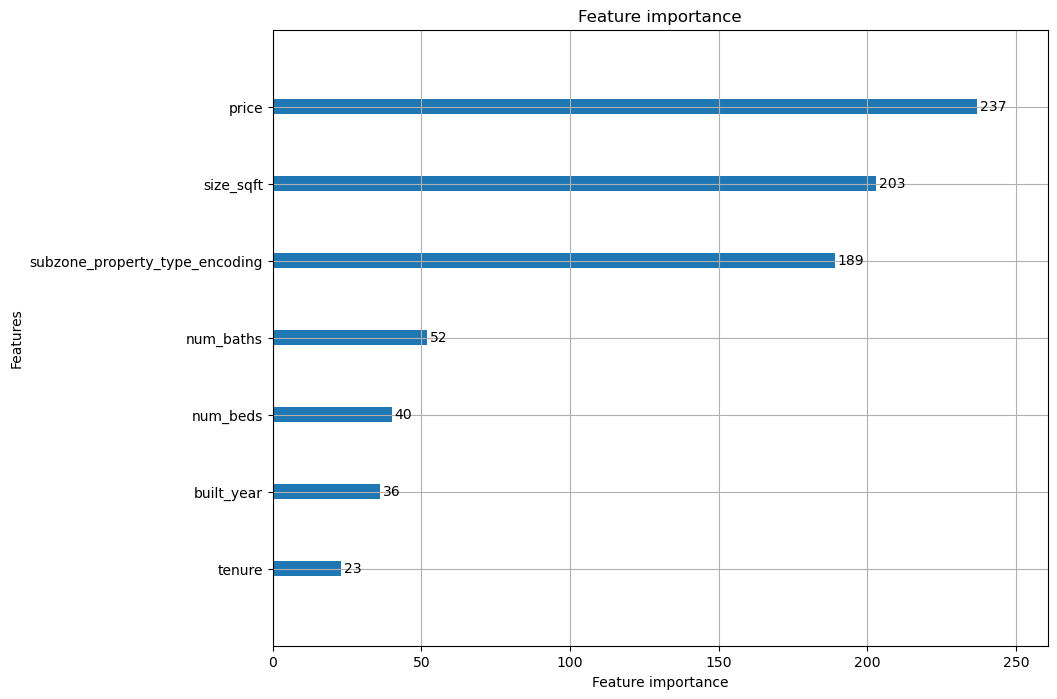

In [29]:
lgb.plot_importance(gbm_model, figsize = (10,8))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

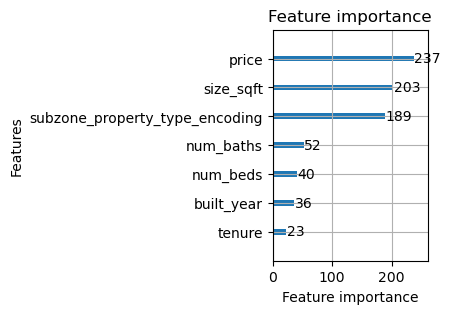

In [31]:
lgb.plot_importance(gbm_model, figsize = (2,3))